In [7]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from pprint import pprint
from keras.utils.np_utils import to_categorical

%matplotlib inline

In [8]:
FILE_NAME = 'data.csv'
MODEL_QUESTIONS_FILE = 'model_questions.h5'
MODEL_ANSWER_FILE = 'model_answer.h5'
MODELS_DATA_FILE = 'models_data.npy'

# Data have 5 scales:
#     +1   : True
#     +0.5 : Maybe true
#     0    : Unknown
#     -0.5 : Maybe false
#     -1   : False

df = pd.read_csv(FILE_NAME, index_col=0)
idx2col = {i:col for i, col in enumerate(df.columns)}
idx2row = {i:row for i, row in enumerate(df.index)}
idx2answer = {1: 'Si', 0.5: 'Creo que si', 0: 'No se', -0.5: 'Creo que no', -1: 'No'}
data = df.values
n_questions = len(idx2col)
n_plates = len(idx2row)

print('Data information:')
print('Number of plates: %d' % n_plates)
print('Number of questions: %d' % n_questions)

Data information:
Number of plates: 41
Number of questions: 23


In [9]:
# Util functions
def is_unique(idx, data):
    idxs = []
    
    for i in range(len(data)):
        if i != idx and np.all(data[idx] == data[i]):
            idxs.append(i)
            
    if len(idxs) == 0:
        return True, None
    else:
        return False, idxs

In [10]:
# Build decision tree
X = data
y = np.arange(n_plates)

clf = tree.DecisionTreeClassifier(max_depth=20, random_state=0, criterion='entropy')
clf = clf.fit(X, y)

In [11]:
# Check decision paths
idx = random.choice(range(n_plates))
t = [clf.tree_.feature[i] for i in clf.decision_path([X[idx]]).indices][:-1]

print('Plate: %s\n\nQuestions:' % idx2row[idx])
pprint([idx2col[i] for i in t])
print('\nCheck uniqueness: %s' % is_unique(idx, data[:, t])[0])

Plate: Caldo de gallina

Questions:
['Lleva cebolla?',
 'Lleva fideos?',
 'Es liquido/sopa?',
 'Lleva pollo/gallina?',
 'Lleva huevo?']

Check uniqueness: True


In [12]:
# Get paths for each plate
plate_paths = []

for idx in range(len(X)):
    path = [clf.tree_.feature[i] for i in clf.decision_path([X[idx]]).indices][:-1]
    plate_paths.append(path)

# pprint(plate_paths)
max_path_length = np.max([len(i) for i in plate_paths])
MAX_Q = int(max_path_length * 2)
print('Max path length: %d' % max_path_length)
print('Max_Q = %d' % MAX_Q)

Max path length: 7
Max_Q = 14


In [13]:
# Train data generator
def generator(data, plates_data, n_q, n_p, mode):
    # TODO: lyer behaviour
    # TODO: unoptimize path
    # TODO: use guess on paths (0.5 or -0.5)
    while True:
        t_x_a = []
        t_x_b = []
        t_y_q = []
        t_y_p = []
        t_y_c = []
        current_plate = 0
        
        for plate, d in enumerate(data):
            for i in range(1, len(d)):
                t_x_a.append(d[:i])
                t_x_b.append(current_plate)
                t_y_q.append(d[i])
                t_y_p.append(plate)
                t_y_c.append(0)
            
            if i < len(d) - 1:
                current_plate += 1
                
            t_x_a.append(d[:i+1])
            t_x_b.append(current_plate)
            t_y_q.append(-1)
            t_y_p.append(plate)
            t_y_c.append(1)
            
        n = len(t_y_q)
        out_x_a = np.zeros((n, n_q))
        out_x_b = np.zeros((n, n_q))
        out_y_q = np.zeros((n, n_q))
        out_y_p = np.zeros((n, n_p))
        out_y_c = np.zeros((n, 2))
        
        for i in range(len(t_x_a)):
            out_x_a[i, :len(t_x_a[i])] = np.asarray(t_x_a[i])
            out_x_b[i, :len(t_x_a[i])] = np.asarray(plates_data[t_x_b[i]][t_x_a[i]])
            out_x = np.hstack([out_x_a, out_x_b])
            out_y_c[i] = to_categorical(t_y_c[i], 2)
            
            if t_y_q[i] > -1:
                out_y_q[i] = to_categorical(t_y_q[i], n_q)
            
            if t_y_p[i] > -1:
                out_y_p[i] = to_categorical(t_y_p[i], n_p)
        
        if mode == 'questions':
            yield [out_x_a, out_x_b], [out_y_q, out_y_c]
        elif mode == 'answers':
            yield out_x_b, out_y_p

In [14]:
# Test generator
data_gen = generator(plate_paths, data, n_questions, n_plates, 'questions')

for i, ([t_x_a, t_x_b], [t_y_q, t_y_c]) in enumerate(data_gen):
    if i == 1:
        break
    
    gen_batch = len(t_x_a)

count = np.unique(t_x_a[:, 0], return_counts=True)
first_question = int(count[0][np.argmax(count[1])])
    
print('Batchs per generator iter: %d' % gen_batch)
print('First question: %d (%s)' % (first_question, idx2col[first_question]))

Batchs per generator iter: 222
First question: 15 (Lleva cebolla?)


Question train


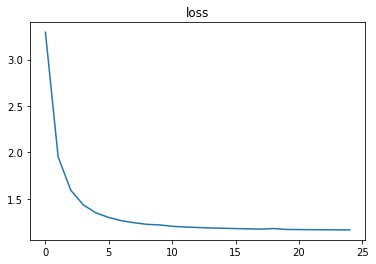

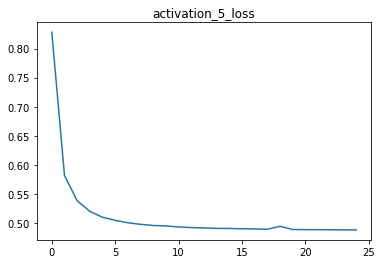

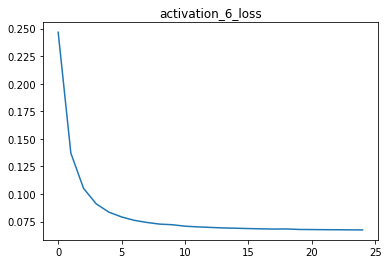

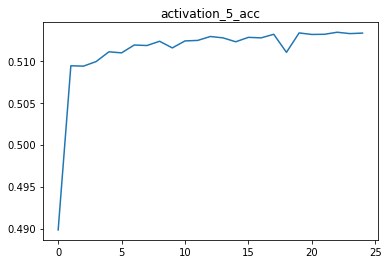

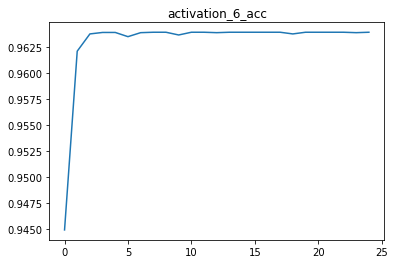

In [15]:
# Build model
from keras.layers import Input, Dense, BatchNormalization, concatenate, Activation
from keras.models import Model
from keras import backend as K
from keras.initializers import Constant

choice_penalty = 10
input_question = Input(shape=(n_questions,))
input_data = Input(shape=(n_questions,))

x1 = concatenate([input_question, input_data], axis=-1)
x1 = Dense(128, kernel_initializer='he_uniform', bias_initializer=Constant(1e-2))(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dense(256, kernel_initializer='he_uniform', bias_initializer=Constant(1e-2))(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x2 = Dense(128, kernel_initializer='he_uniform', bias_initializer=Constant(1e-2))(input_data)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dense(256, activation='relu', kernel_initializer='he_uniform', bias_initializer=Constant(1e-2))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

out_question = Dense(n_questions)(x1)
out_question = BatchNormalization()(out_question)
out_question = Activation('softmax')(out_question)
out_choice = Dense(2)(x1)
out_choice = BatchNormalization()(out_choice)
out_choice = Activation('softmax')(out_choice)
out_answer = Dense(n_plates)(x2)
out_answer = BatchNormalization()(out_answer)
out_answer = Activation('softmax')(out_answer)

model1 = Model(inputs=[input_question, input_data], outputs=[out_question, out_choice])
model1.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'], 
              loss_weights=[1, choice_penalty])

model2 = Model(inputs=input_data, outputs=out_answer)
model2.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

print('Question train')
gen = generator(plate_paths, data, n_questions, n_plates, 'questions')
h = model1.fit_generator(gen, gen_batch, 25, verbose=0)

for k in h.history.keys():
    plt.plot(h.history[k])
    plt.title(k)
    plt.show()

Answer train


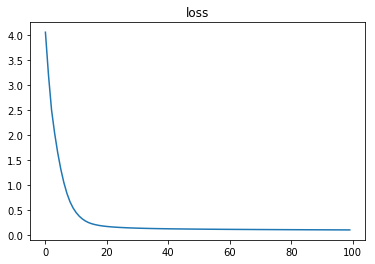

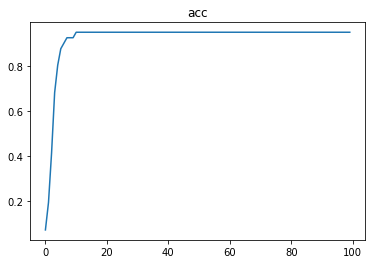

In [16]:
print('Answer train')
h = model2.fit(x=data, y=np.identity(len(data)), batch_size=128, epochs=100, verbose=0)

for k in h.history.keys():
    plt.plot(h.history[k])
    plt.title(k)
    plt.show()

In [17]:
# Model utils
def build_input(path, data):
    out_a = np.zeros_like(data)
    out_b = np.zeros_like(data)
    out_a[:len(path)] = np.asarray(path)
    out_a = out_a.reshape([1, -1])
    out_b[:len(path)] = data[path]
    out_b = out_b.reshape([1, -1])
    
    return [out_a, out_b]

def get_output(y, top=5):
    questions, choice = y
    out_type = 'question' if np.argmax(choice) == 0 else 'answer'
    top_idx = questions.argsort()[0][::-1][:top]
    top_prb = questions[0, top_idx]
    
    return out_type, top_idx, top_prb

In [33]:
# Get random test
choice = random.choice(range(len(X)))
choice = random.choice(errors)
plate_name = idx2row[y[choice]]
plate_data = X[choice]
plate_best_path = plate_paths[choice]
print('Target plate: %s' % plate_name)
print('Optimal path of questions: %s' % [idx2col[i] for i in plate_best_path])

# Ask questions
test_path = []
i = 0
pred_type = 'question'

while pred_type != 'answer':
    if i == 0:
        pred_type = 'question'
        pred_val = first_question
    else:
        pred = model1.predict(build_input(test_path, plate_data))
        limit = n_questions
        pred_type, pred_vals, pred_probs = get_output(pred, limit)
        
        for j in range(limit):
            if pred_vals[j] in test_path:
                continue
            else:
                pred_val = pred_vals[j]
                break
   
    unique_plate, possible_plates = is_unique(choice, data[:, test_path])
        
    if not unique_plate and i < MAX_Q:
        print('\nQuestion #%d' % (i + 1))
        print('%s (%s)' % (idx2col[pred_val], idx2answer[plate_data[pred_val]]))
        pred_type = 'question'
    else:
        break
        
    test_path.append(pred_val)
    i += 1
    
answer = np.zeros_like(plate_data)
idxs = np.unique([i for i in test_path if i is not None])
answer[idxs] = plate_data[idxs]
pred2 = model2.predict(answer.reshape([1,-1]))
top_5_idx = pred2.argsort()[0][::-1][:5]
top_5_txt = [idx2row[i] for i in top_5_idx]
top_5_prb = pred2[0, top_5_idx]

print('\nAnswer probs:')
print('Real answer: %s' % plate_name)

for i in zip(top_5_txt, top_5_prb):
    print('%-25s = %.2f %%' % (i[0], i[1]*100))
    
unique_plate, possible_plates = is_unique(choice, data[:, test_path])
print('\nCheck uniqueness: %s' % unique_plate)

if not unique_plate:
    print(idx2row[choice], end=', ')
    print(', '.join([idx2row[i] for i in possible_plates]), end='.')

Target plate: Rocoto relleno
Optimal path of questions: ['Lleva cebolla?', 'Lleva fideos?', 'Lleva carne de res?', 'Lleva papas?', 'Consiste en algun relleno o masa de harina?']

Question #1
Lleva cebolla? (Si)

Question #2
Lleva pollo/gallina? (No)

Question #3
Es liquido/sopa? (No)

Question #4
Lleva algun tipo de carne, pescado o mariscos? (Si)

Question #5
Lleva salsa de tomates? (No)

Question #6
Lleva fideos? (No)

Question #7
Es comida china? (No)

Question #8
Consiste en algun relleno o masa de harina? (Si)

Question #9
Lleva zapallo? (No)

Question #10
Lleva arroz? (No)

Question #11
Lleva pescado? (No)

Question #12
Lleva chicha de jora? (No)

Question #13
Lleva chancho? (No)

Question #14
Lleva carne de res? (Si)

Answer probs:
Real answer: Rocoto relleno
Papa rellena              = 73.77 %
Rocoto relleno            = 26.12 %
Quesadilla                = 0.00 %
Tequeños                  = 0.00 %
Humita dulce              = 0.00 %

Check uniqueness: False
Rocoto relleno, Papa 

In [22]:
# Build check training data
f_extra_train_X = np.zeros((0, n_questions))
f_extra_train_y = np.zeros((0, n_plates))
f_extra_train_weights = np.array([])
errors = []
MIN_Q_TRAIN = 5
MAX_Q_TRAIN = 15

for M_Q in range(MIN_Q_TRAIN, MAX_Q_TRAIN):
    extra_train_X = np.zeros_like(data)
    extra_train_weights = np.ones(n_plates)
    
    for idx in range(n_plates):
        choice = idx
        plate_name = idx2row[y[choice]]
        plate_data = X[choice]

        # Ask questions
        test_path = []
        i = 0
        pred_type = 'question'

        while pred_type != 'answer':
            if i == 0:
                pred_type = 'question'
                pred_val = first_question
            else:
                pred = model1.predict(build_input(test_path, plate_data))
                limit = n_questions
                pred_type, pred_vals, pred_probs = get_output(pred, limit)

                for j in range(limit):
                    if pred_vals[j] in test_path:
                        continue
                    else:
                        pred_val = pred_vals[j]
                        break

            unique_plate, possible_plates = is_unique(choice, data[:, test_path])

            if not unique_plate and i < M_Q:
                pred_type = 'question'
            else:
                break

            test_path.append(pred_val)
            i += 1

        answer = np.zeros_like(plate_data)
        idxs = np.unique([i for i in test_path if i is not None])
        answer[idxs] = plate_data[idxs]
        pred2 = model2.predict(answer.reshape([1,-1]))
        pred2 = np.argmax(pred2)

        extra_train_X[idx] = answer
    
        if idx != pred2 and M_Q == MAX_Q:
            extra_train_weights[idx] = 3
            errors.append(idx)
    
    if M_Q == MAX_Q:
        print('Errors = %d' % len(errors))
        print([idx2row[i] for i in errors])
        
    f_extra_train_X = np.vstack([f_extra_train_X, extra_train_X])
    f_extra_train_y = np.vstack([f_extra_train_y, np.identity(len(data))])
    f_extra_train_weights = np.hstack([f_extra_train_weights, extra_train_weights])

Errors = 10
['Arroz con pollo peruano', 'Aji de gallina', 'Carapulcra', 'Quesadilla', 'Köttbullar', 'Tequeños', 'Parihuela', 'Tamal de pollo', 'Arroz con pollo', 'Rocoto relleno']


In [20]:
MAX_Q

14

In [ ]:
MAX_Q = 12
MAX_Q

Final train:


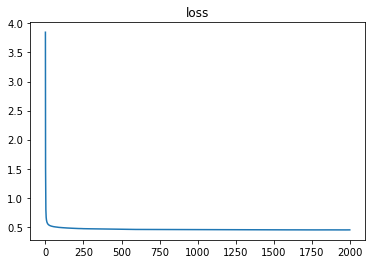

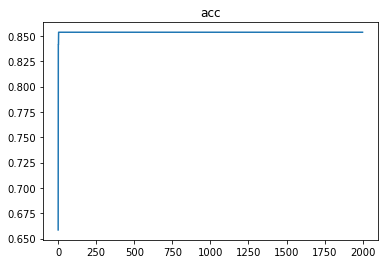

In [21]:
print('Final train:')
train_X = np.vstack([data, extra_train_X])
train_y = np.vstack([np.identity(len(data)), np.identity(len(data))])
train_weights = np.hstack([np.ones(n_plates), extra_train_weights])
h = model2.fit(x=train_X, y=train_y, sample_weight=train_weights, batch_size=128, epochs=2000, verbose=0)

for k in h.history.keys():
    plt.plot(h.history[k])
    plt.title(k)
    plt.show()

In [34]:
# Save files
model1.save(MODEL_QUESTIONS_FILE)
model2.save(MODEL_ANSWER_FILE)
models_data = np.asarray([MAX_Q, first_question], dtype=int)
np.save(MODELS_DATA_FILE, models_data)